In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import yaml
import os

In [7]:
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])

config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [2]:
# may differ depending on the problem
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]) # put more transforms options here

In [3]:
# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

100%|██████████| 170498071/170498071 [00:19<00:00, 8731956.14it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [9]:
imgs, labels = next(iter(validation_loader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

Image Shapes: torch.Size([64, 3, 32, 32])
Label Shapes: torch.Size([64])


In [48]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x
    
def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
            return nn.Sequential(nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
            nn.GELU(),
            nn.BatchNorm2d(dim),
            *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim))
            for i in range(depth)],      
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(dim, n_classes))

In [49]:
from tqdm import tqdm

In [50]:
NUM_EPOCHS = int(config["NUM_EPOCHS"])
LR = float(config["LR"])

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvMixer(dim=256, depth=4, kernel_size=8,patch_size=1, n_classes=10)
model = model.to(device)

In [58]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) #adamW was used in the paper
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, 
        base_lr=0.0001, max_lr = LR, cycle_momentum=False)

In [59]:
@torch.no_grad()
def eval_model(model):
    """ Computing model accuracy """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss

In [60]:
EPOCHS = config["NUM_EPOCHS"]
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": []
}

In [61]:
loss_hist = []

for epoch in range(EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(training_loader), total=len(training_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])
    # evaluating model
    accuracy, valid_loss = eval_model(model)  
    print(f"Val accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)

Epoch 1 Iter 1: loss 2.33426. :   0%|          | 1/782 [00:15<3:18:00, 15.21s/it]


KeyboardInterrupt: 

In [35]:
accuracy, _ = eval_model(model)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 57.5%


In [36]:
epochs = np.array(stats["epoch"])
train_loss = np.array(stats["train_loss"])

eval_loss = np.array(stats["valid_loss"])
accuracy = np.array(stats["accuracy"])
eval_idx = np.where(eval_loss != -1)[0]

In [37]:
eval_loss

array([1.22142765, 1.22056449, 1.21779441, 1.21178113, 1.20420773,
       1.21324593, 1.21122236, 1.20515199, 1.20021623, 1.19514381])

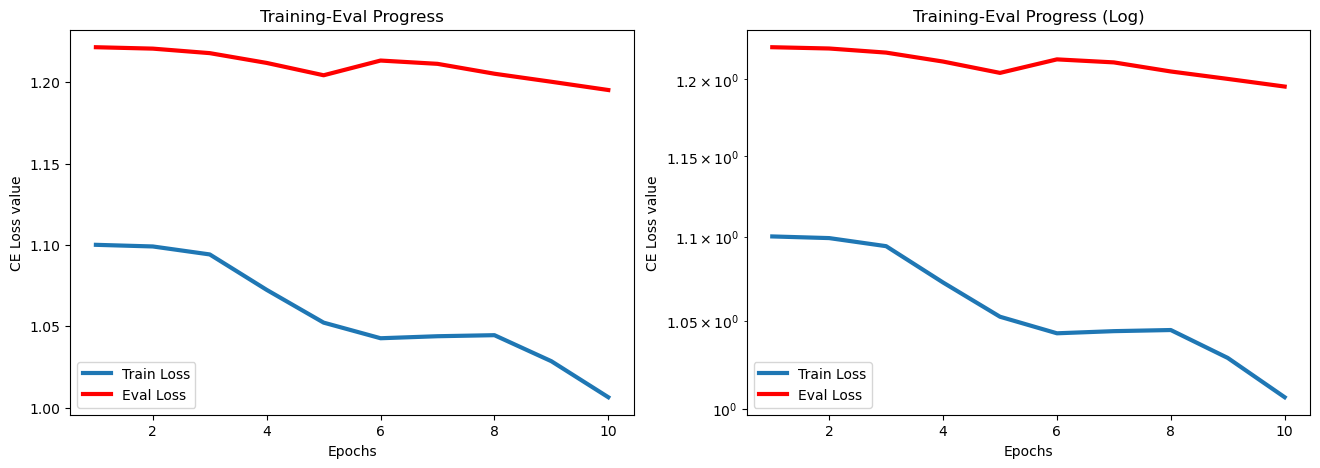

In [38]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

for a in ax:

    a.plot(epochs+1, train_loss, label="Train Loss", linewidth=3)
    a.plot(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", label="Eval Loss", linewidth=3)
#     a.scatter(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", s=100, marker="x")
    a.legend(loc="best")
    a.set_xlabel("Epochs")
    a.set_ylabel("CE Loss value")

ax[0].set_title("Training-Eval Progress")
ax[1].set_title("Training-Eval Progress (Log)")
ax[1].set_yscale("log")

plt.show()